# Datetime Manipulations and Rolling Windows

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

### Example 1: Dogecoin

In [9]:
doge = pd.read_csv('../data/DOGE-USD.csv')

doge.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-26,0.002539,0.002542,0.002472,0.002486,0.002486,185485979.0
1,2020-05-27,0.002486,0.002529,0.002472,0.002510,0.002510,186186772.0


In order to do datetime manipulations, we first need to tell pandas to treat the Date columns as a datetime object.

In [10]:
doge['Date'] = pd.to_datetime(doge['Date'])

doge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       366 non-null    datetime64[ns]
 1   Open       363 non-null    float64       
 2   High       363 non-null    float64       
 3   Low        363 non-null    float64       
 4   Close      363 non-null    float64       
 5   Adj Close  363 non-null    float64       
 6   Volume     363 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 20.1 KB


Now that the Date column is a datetime object, we can do datetime manipulations, like extracting the month.

Similar to working with strings, to access datetime attributes you need to include `.dt` before the attribute you want to extract.

In [12]:
doge['Date'].dt.month

0      5
1      5
2      5
3      5
4      5
      ..
361    5
362    5
363    5
364    5
365    5
Name: Date, Length: 366, dtype: int64

We only need the Date and Close columns, so we'll slice down to just those two.

In [13]:
doge = doge[['Date', 'Close']]

First, let's look at the trend in closing price by day.

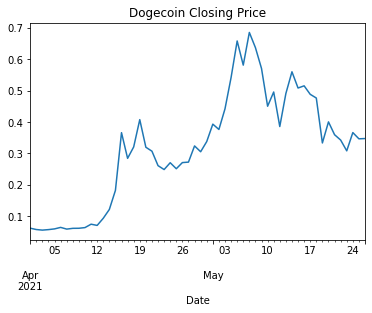

In [15]:
doge[doge.Date >= '04-01-2021'].set_index('Date')['Close'].plot()
plt.title('Dogecoin Closing Price');
#plt.tight_layout()
#plt.savefig('../images/doge/doge_01.png', dpi = 150);

Then, we can smooth out the trend by calculating a moving 7 day average.

In [16]:
doge['rolling_7_day_average'] = doge.rolling('7d', on = 'Date')['Close'].mean()

Let's see what the plot looks like now.

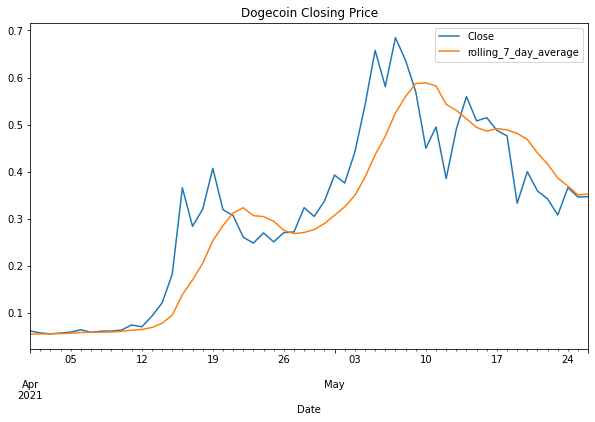

In [18]:
fig, ax = plt.subplots(figsize = (10,6))

doge[doge.Date >= '04-01-2021'].set_index('Date')[['Close', 'rolling_7_day_average']].plot(ax = ax)
plt.title('Dogecoin Closing Price');
#plt.tight_layout()
#plt.savefig('../images/doge/doge_02.png', dpi = 150);

### Example 2: Davidson County Crashes Data

In [19]:
traffic = pd.read_csv('../data/Traffic_Accidents.csv')

Convert to datetime and extract the date portion.

In [21]:
traffic['Date and Time'] = pd.to_datetime(traffic['Date and Time'])

traffic['date'] = traffic['Date and Time'].dt.date

First, we'll do a count per day of crashes.

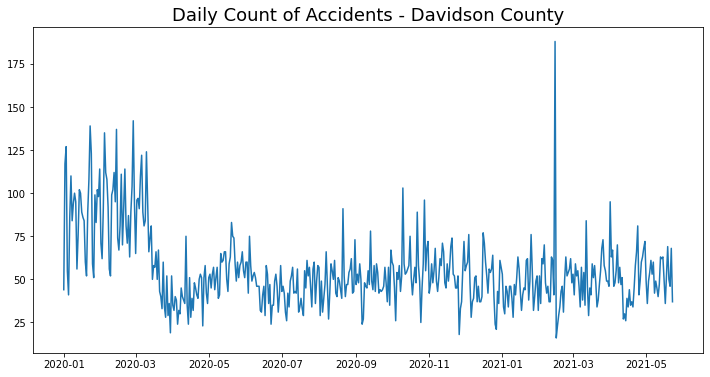

In [22]:
plt.figure(figsize = (12,6))
traffic.date.value_counts().sort_index().plot()
plt.title('Daily Count of Accidents - Davidson County', fontsize = 18);

#plt.tight_layout()
#plt.savefig('../images/crashes/dc_crashes01.png', dpi = 150);

Then, we can compare this to a rolling 30 day average.

In [23]:
traffic = traffic.sort_values('Date and Time')

traffic['total_crashes_30_days'] = (traffic
                                    .rolling('30d', on = 'Date and Time')['Accident Number']
                                    .count())

traffic['rolling_daily_average'] = traffic['total_crashes_30_days'] / 30

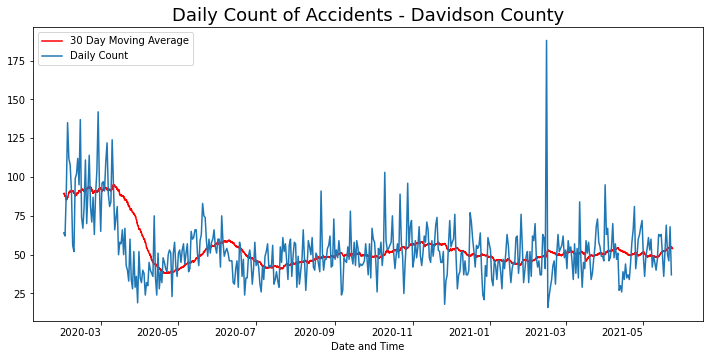

In [24]:
plt.figure(figsize = (12,6))
traffic[traffic['Date and Time'] > '02/01/2020'].set_index('Date and Time')['rolling_daily_average'].plot(color = 'red', label = '30 Day Moving Average')
traffic[traffic['Date and Time'] > '02/01/2020'].date.value_counts().sort_index().plot(label = 'Daily Count')
plt.title('Daily Count of Accidents - Davidson County', fontsize = 18)
plt.legend();
#plt.tight_layout()
#plt.savefig('../images/crashes/dc_crashes02.png', dpi = 150);

We can also look at the trend by precinct.

In [25]:
traffic_by_precinct = (traffic
                       .groupby('Precinct')
                       .rolling('30d', on = 'Date and Time')['Accident Number']
                       .count()
                       .reset_index()
                       .set_index('Date and Time')
                      )
traffic_by_precinct['rolling_daily_average'] = traffic_by_precinct['Accident Number'] / 30 

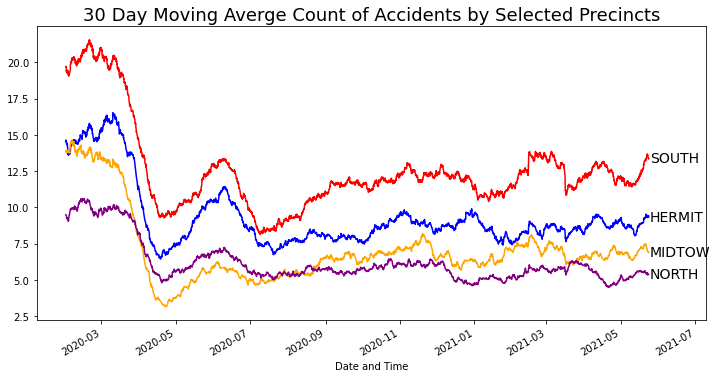

In [26]:
plt.figure(figsize = (12, 6))

for precinct, color in zip(['SOUTH', 'HERMIT', 'MIDTOW', 'NORTH'], ['red', 'blue', 'orange', 'purple']):
    traffic_by_precinct[(traffic_by_precinct.index > '02-01-2020') & (traffic_by_precinct.Precinct == precinct)]['rolling_daily_average'].plot(label = precinct, color = color)

    plt.annotate(text = precinct,
                 xy = ('2021-05-25', traffic_by_precinct[traffic_by_precinct.Precinct == precinct]['rolling_daily_average'].tolist()[-1]),
                va = 'center', ha = 'left', fontsize = 14)
        
xmin, xmax = plt.xlim()
plt.xlim(xmin, '2021-07-10')

plt.title('30 Day Moving Averge Count of Accidents by Selected Precincts', fontsize = 18);
#plt.tight_layout()
#plt.savefig('../images/crashes/dc_crashes03.png', dpi = 150);